In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath'])
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})

%matplotlib inline
palette = sns.color_palette()

In [2]:
class DiscStd(nn.Module):
    def __init__(self, num_envs):
        super(DiscStd, self).__init__()
        self.linear = nn.Linear(2, num_envs, bias=True)
    def forward(self, x):
        f = torch.cat([x, x ** 2], dim=1)
        return self.linear(f)

    
def disc_loss_std(z_list, D):
    z_batch = torch.cat(z_list).unsqueeze(1)
    target = torch.arange(len(z_list), dtype=torch.int64)
    
    out = D(z_batch)
    loss = F.cross_entropy(out, target)
    return loss


def gen_loss_std(z_list, D):
    return -disc_loss_std(z_list, D)

    
class DiscDirac(nn.Module):
    def __init__(self):
        super(DiscDirac, self).__init__()
        self.psi = nn.Parameter(torch.tensor([0.1]))
        
    def forward(self, x):
        return self.psi * x

    
def disc_loss_dirac(z_list, D):
    assert len(z_list) == 2
    z_batch = torch.cat(z_list)
    target = torch.arange(len(z_list), dtype=torch.float32)
    
    out = D(z_batch)
    loss = F.binary_cross_entropy_with_logits(out, target)
    return loss


def gen_loss_dirac(z_list, D):
    return -disc_loss_dirac(z_list, D)
    
    
class DiscPair(nn.Module):
    def __init__(self, gamma=1.3):
        super(DiscPair, self).__init__()
        self.psi = nn.Parameter(torch.tensor([0.1]))
        self.gamma = gamma
        
    def forward(self, x, y):
        s = torch.sum(torch.abs(x - y) ** self.gamma, dim=-1)
        return self.psi * s

    
pos_label = 0
neg_label = 1


def disc_loss_pair(z_list, D):
    N = len(z_list)
    x_p_batch = torch.cat(z_list).unsqueeze(1)
    y_p_batch = torch.cat(z_list).unsqueeze(1)
    out_p = D(x_p_batch, y_p_batch)
    target_p = torch.tensor([pos_label] * len(z_list), dtype=torch.float32)
    
    neg_list = [(x, y) for (x, y) in itertools.combinations(z_list, 2)]
    x_n_batch = torch.cat([xy[0] for xy in neg_list]).unsqueeze(1)
    y_n_batch = torch.cat([xy[1] for xy in neg_list]).unsqueeze(1)
    out_n = D(x_n_batch, y_n_batch)
    target_n = torch.tensor([neg_label] * len(neg_list), dtype=torch.float32)
    
    loss = (N - 1) * F.binary_cross_entropy_with_logits(out_p, target_p) +\
           2 * F.binary_cross_entropy_with_logits(out_n, target_n)
    return loss
    

def gen_loss_pair(z_list, D):
    N = len(z_list)
    x_p_batch = torch.cat(z_list).unsqueeze(1)
    y_p_batch = torch.cat(z_list).unsqueeze(1)
    out_p = D(x_p_batch, y_p_batch)
    target_p = torch.tensor([neg_label] * len(z_list), dtype=torch.float32)
    
    neg_list = [(x, y) for (x, y) in itertools.combinations(z_list, 2)]
    x_n_batch = torch.cat([xy[0] for xy in neg_list]).unsqueeze(1)
    y_n_batch = torch.cat([xy[1] for xy in neg_list]).unsqueeze(1)
    out_n = D(x_n_batch, y_n_batch)
    target_n = torch.tensor([neg_label] * len(neg_list), dtype=torch.float32)
    
    loss = (N - 1) * F.binary_cross_entropy_with_logits(out_p, target_p) -\
           2 * F.binary_cross_entropy_with_logits(out_n, target_n)
    return loss

In [3]:
def make_step(z_list, D, loss_fn, opt):
    opt.zero_grad()
    loss = loss_fn(z_list, D)
    loss.backward()
    opt.step()
    return loss.item()


def l2_reg_loss(D, coeff):
    return 0.5 * coeff * sum([torch.sum(p ** 2) for p in D.parameters()], torch.tensor([0.0])) 
    
    
def run_gd(z_list, D, G_loss, D_loss, g_lr=0.01, d_lr=0.1, d_l2_coeff=None, num_steps=100, save_psi=False):
    G_opt = torch.optim.SGD(z_list, lr=g_lr)
    D_opt = torch.optim.SGD(D.parameters(), lr=d_lr)
    
    if d_l2_coeff is not None:
        D_loss_old = D_loss
        D_loss = lambda z_list, D: D_loss_old(z_list, D) + l2_reg_loss(D, d_l2_coeff)
    
    tr_z = np.zeros((num_steps + 1, len(z_list)))
    tr_z[0, :] = np.array([z.item() for z in z_list])
    
    if save_psi:
        tr_psi = np.zeros(num_steps + 1)
        tr_psi[0] = D.psi.item()
    
    for i in range(num_steps):
        for j in range(1):
            d_loss = make_step(z_list, D, D_loss, D_opt)
        g_loss = make_step(z_list, D, G_loss, G_opt)
        tr_z[i + 1, :] = np.array([z.item() for z in z_list])
        if save_psi:
            tr_psi[i + 1] = D.psi.item()
    
    return (tr_z, tr_psi) if save_psi else tr_z
    

## Three distributions

### Standard discriminator

In [4]:
init_vals = [0.2, 0.1, -0.3]
num_envs = len(init_vals)
z_list = [torch.tensor([v], requires_grad=True) for v in init_vals]
torch.random.manual_seed(9)
D_std = DiscStd(len(z_list))
tr_std = run_gd(
    z_list, D_std, gen_loss_std, disc_loss_std,
    g_lr=0.01, d_lr=0.08, d_l2_coeff=0.05, num_steps=1000)

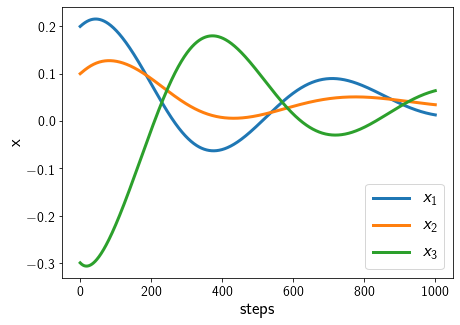

In [5]:
plt.figure(figsize=(7, 5))
for i in range(tr_std.shape[1]):
    plt.plot(tr_std[:, i], linewidth=3, c=palette[i], label='$x_%d$' % (i + 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('x', fontsize=18)
plt.xlabel('steps', fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Pairwise discriminator

In [6]:
init_vals = [0.2, 0.1, -0.3]
num_envs = len(init_vals)
z_list = [torch.tensor([v], requires_grad=True) for v in init_vals]
D_pair = DiscPair(gamma=1.3)
tr_pair = run_gd(z_list, D_pair, gen_loss_pair, disc_loss_pair, g_lr=0.002, d_lr=0.007, num_steps=1000)

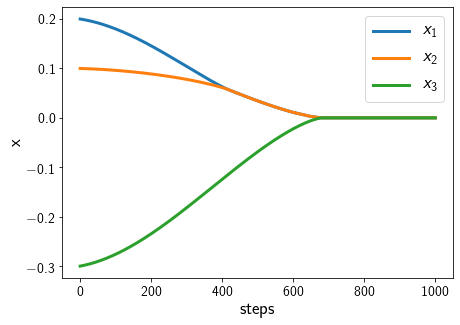

In [7]:
plt.figure(figsize=(7, 5))
for i in range(tr_pair.shape[1]):
    plt.plot(tr_pair[:, i], linewidth=3, c=palette[i], label='$x_%d$' % (i + 1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('x', fontsize=18)
plt.xlabel('steps', fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Figure

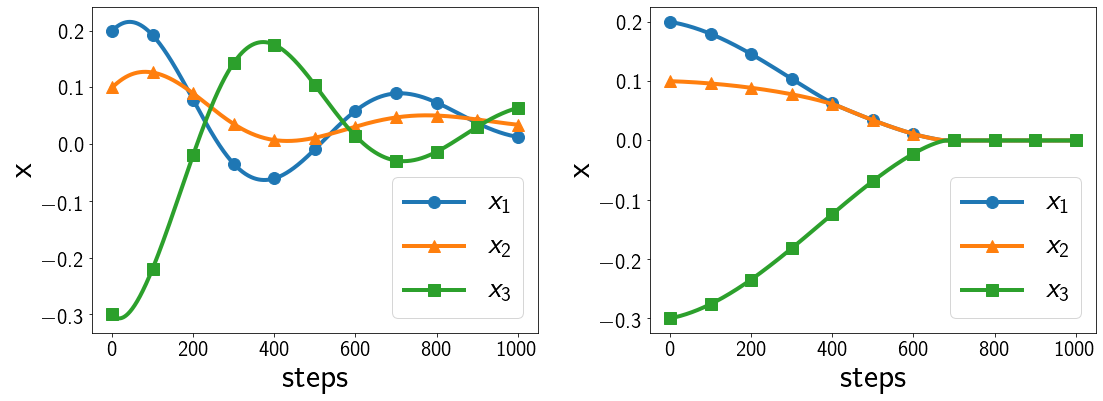

In [8]:
fig, axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)

plt.sca(axes[0])
for i in range(tr_std.shape[1]):
    plt.plot(tr_std[:, i], linewidth=4, c=palette[i], label='$x_%d$' % (i + 1), 
             marker=['o', '^', 's'][i], markevery=(0, 100), markersize=12)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('x', fontsize=34)
plt.xlabel('steps', fontsize=34)
plt.legend(fontsize=30, loc=4)

plt.sca(axes[1])
for i in range(tr_pair.shape[1]):
    plt.plot(tr_pair[:, i], linewidth=4, c=palette[i], label='$x_%d$' % (i + 1),
             marker=['o', '^', 's'][i], markevery=(0, 100), markersize=12)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('x', fontsize=34)
plt.xlabel('steps', fontsize=34)
plt.legend(fontsize=30, loc=4)

plt.subplots_adjust(wspace=0.25)
plt.savefig('./figures/fig_mult.pdf', format='pdf', bbox_inches='tight')
plt.show()

## DiracGAN

### Standard discriminator

In [9]:
z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.6], requires_grad=True)
]

D_dirac = DiscDirac()
D_dirac.psi.data = torch.tensor([-0.2])

g_lr_dirac = 0.05
d_lr_dirac = 0.05

tr_z_dirac, tr_psi_dirac = run_gd(
    z_list, D_dirac, gen_loss_dirac, disc_loss_dirac,
    g_lr=g_lr_dirac, d_lr=d_lr_dirac, num_steps=2000, save_psi=True
)

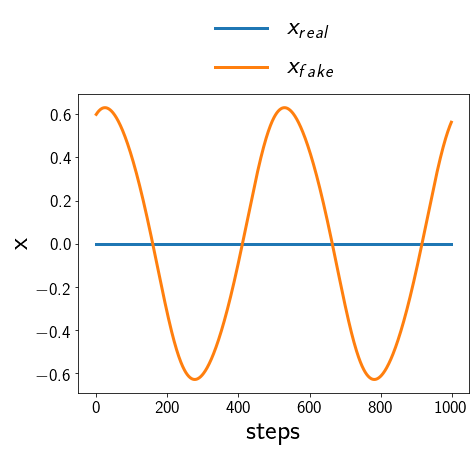

In [10]:
plt.figure(figsize=(7, 5.5))
K = 1000
plt.plot(tr_z_dirac[:K, 0], linewidth=3, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac[:K, 1], linewidth=3, c=palette[1], label='$x_{fake}$')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('x', fontsize=28)
plt.xlabel('steps', fontsize=28)
plt.legend(fontsize=26, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)
plt.show()

### Pairwise discriminator

In [11]:
z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.6], requires_grad=True)
]

D_dirac_pair = DiscPair()
D_dirac_pair.psi.data = torch.tensor([-0.2])

g_lr_dirac_pair = 0.008
d_lr_dirac_pair = 0.008

tr_z_dirac_pair, tr_psi_dirac_pair = run_gd(
    z_list, D_dirac_pair, gen_loss_pair, disc_loss_pair, 
    g_lr=g_lr_dirac_pair, d_lr=d_lr_dirac_pair, num_steps=1000, save_psi=True)

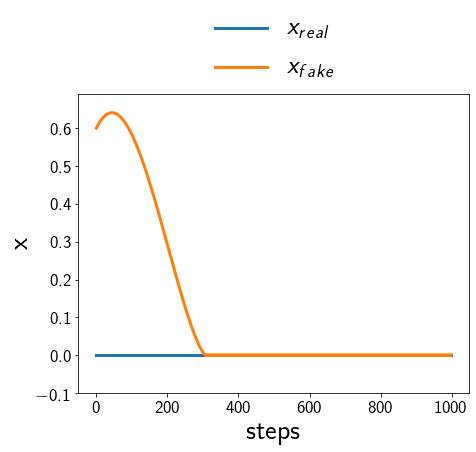

In [12]:
plt.figure(figsize=(7, 5.5))
plt.plot(tr_z_dirac_pair[:K, 0], linewidth=3, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac_pair[:K, 1], linewidth=3, c=palette[1], label='$x_{fake}$')
plt.ylim([-0.1, 0.69])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('x', fontsize=28)
plt.xlabel('steps', fontsize=28)
plt.legend(fontsize=26, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)
plt.show()

### Vector field

In [13]:
def zero_grad(v):
    if v.grad is not None:
        v.grad.detach_()
        v.grad.zero_()

        
def vector_field(z_grid, psi_grid, disc, disc_loss, gen_loss, z_0=0.0):

    z_0 = torch.tensor([z_0], requires_grad=False)
    z = torch.tensor([0.0], requires_grad=True)
    Z, PSI = np.meshgrid(z_grid, psi_grid)

    Z_grad = np.zeros((psi_grid.size, z_grid.size))
    PSI_grad = np.zeros((psi_grid.size, z_grid.size))


    for i, z_val in enumerate(z_grid):
        for j, psi_val in enumerate(psi_grid):
            z.data = torch.tensor([z_val])
            disc.psi.data = torch.tensor([psi_val])

            zero_grad(disc.psi)
            d_loss = disc_loss([z_0, z], disc)
            d_loss.backward()

            PSI_grad[j, i] = -disc.psi.grad.item()

            zero_grad(z)
            g_loss = gen_loss([z_0, z], disc)
            g_loss.backward()

            Z_grad[j, i] = -z.grad.item()
    return Z, PSI, Z_grad, PSI_grad

### Vector field. Standard discriminator

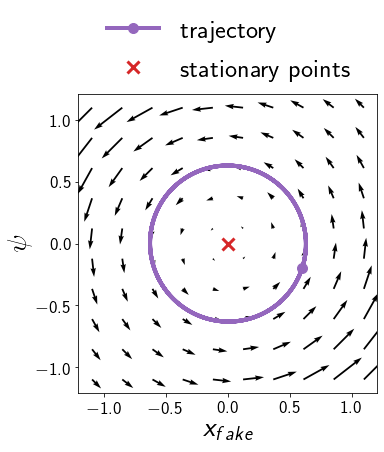

In [14]:
Z, PSI, Z_grad, PSI_grad = vector_field(
    z_grid=np.linspace(-1.1, 1.1, 10),
    psi_grid=np.linspace(-1.1, 1.1, 10),
    disc=DiscDirac(),
    disc_loss=disc_loss_dirac,
    gen_loss=gen_loss_dirac,
)


plt.figure(figsize=(5.5, 5.5))
plt.quiver(Z, PSI, Z_grad * g_lr_dirac, PSI_grad * d_lr_dirac)
plt.plot(tr_z_dirac[:, 1], tr_psi_dirac, linewidth=4, c=palette[4], label='trajectory',
         marker='o', markersize=10, markevery=(0, tr_z_dirac.shape[0]))
#plt.axvline(0, linestyle='--', linewidth=2, c=palette[3])
plt.plot([0], [0], 'x', markersize=12, c=palette[3], markeredgewidth=3, label='stationary points')
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=28)
plt.ylabel('$\psi$', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=26, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)
plt.show()

### Vector field. Pairwise discriminator

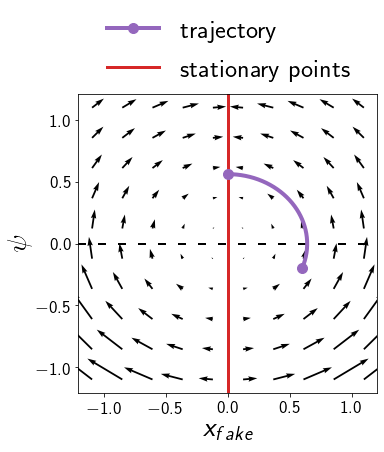

In [15]:
Z_pair, PSI_pair, Z_grad_pair, PSI_grad_pair = vector_field(
    z_grid=np.linspace(-1.1, 1.1, 10),
    psi_grid=np.linspace(-1.1, 1.1, 10),
    disc=DiscPair(),
    disc_loss=disc_loss_pair,
    gen_loss=gen_loss_pair,
)

plt.figure(figsize=(5.5, 5.5))
plt.axhline(0, linestyle='--', dashes=(4, 6), linewidth=2, c='k')
plt.quiver(Z_pair, PSI_pair, Z_grad_pair * g_lr_dirac_pair, PSI_grad_pair * d_lr_dirac_pair)
plt.plot(tr_z_dirac_pair[:, 1], tr_psi_dirac_pair, linewidth=4, c=palette[4],
         marker='o', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=10, label='trajectory', zorder=3)
plt.axvline(0, linestyle='-', linewidth=3, c=palette[3], label='stationary points', zorder=2)
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=28)
plt.ylabel('$\psi$', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=26, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)
plt.show()

### Figure

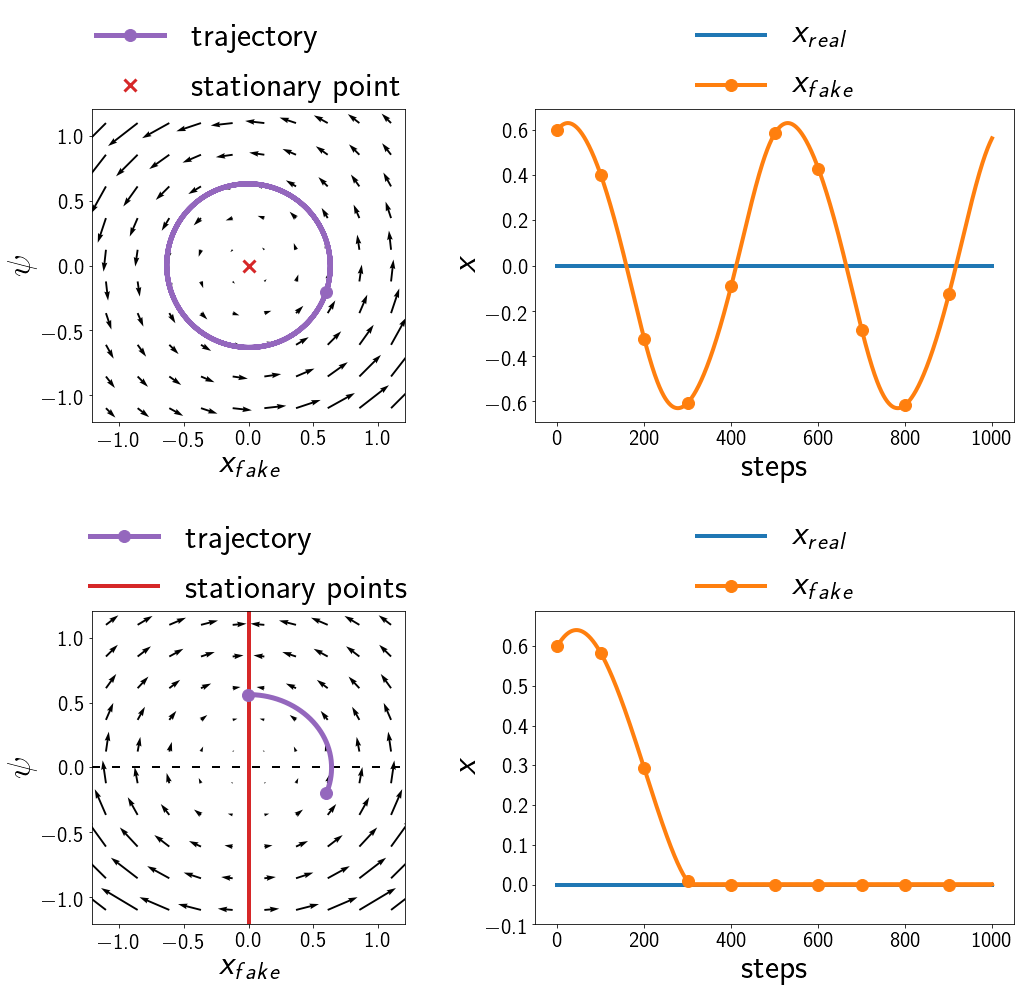

In [16]:
fig, axes = plt.subplots(figsize=(18, 15), nrows=2, ncols=2)

plt.sca(axes[0][0])
plt.quiver(Z, PSI, Z_grad * g_lr_dirac, PSI_grad * d_lr_dirac)
plt.plot(tr_z_dirac[:, 1], tr_psi_dirac, linewidth=5, c=palette[4], label='trajectory',
         marker='o', markersize=12, markevery=(0, tr_z_dirac.shape[0]))
#plt.axvline(0, linestyle='--', linewidth=2, c=palette[3])
plt.plot([0], [0], 'x', markersize=12, c=palette[3], markeredgewidth=3, label='stationary point')
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=34)
plt.ylabel('$\psi$', fontsize=34)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=34, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)


plt.sca(axes[1][0])
plt.axhline(0, linestyle='--', dashes=(4, 6), linewidth=2, c='k')
plt.quiver(Z_pair, PSI_pair, Z_grad_pair * g_lr_dirac_pair, PSI_grad_pair * d_lr_dirac_pair)
plt.plot(tr_z_dirac_pair[:, 1], tr_psi_dirac_pair, linewidth=5, c=palette[4],
         marker='o', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=12, label='trajectory', zorder=3)
plt.axvline(0, linestyle='-', linewidth=4, c=palette[3], label='stationary points', zorder=2)
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=34)
plt.ylabel('$\psi$', fontsize=34)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=34, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)

K = 1000
plt.sca(axes[0][1])
plt.plot(tr_z_dirac[:K, 0], linewidth=4, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac[:K, 1], linewidth=4, c=palette[1], label='$x_{fake}$',
        marker='o', markevery=(0, 100), markersize=12)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('$x$', fontsize=34)
plt.xlabel('steps', fontsize=34)
plt.legend(fontsize=34, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)

plt.sca(axes[1][1])
plt.plot(tr_z_dirac_pair[:K, 0], linewidth=4, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac_pair[:K, 1], linewidth=4, c=palette[1], label='$x_{fake}$',
         marker='o', markevery=(0, 100), markersize=12)
plt.ylim([-0.1, 0.69])
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylabel('$x$', fontsize=34)
plt.xlabel('steps', fontsize=34)
plt.legend(fontsize=34, bbox_to_anchor=(0.5, 1.15), loc='center', ncol=1, frameon=False)

plt.subplots_adjust(wspace=0.1, hspace=0.6)
plt.savefig('./figures/fig1.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Convergence plots

### Standard discriminator

In [17]:
z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.6], requires_grad=True)
]

D_dirac = DiscDirac()
D_dirac.psi.data = torch.tensor([-0.3])

g_lr_dirac_gp = 0.05
d_lr_dirac_gp = 0.05
d_gp_dirac_gp=0.15

tr_z_dirac_gp_1, tr_psi_dirac_gp_1 = run_gd(
    z_list, D_dirac, gen_loss_dirac, disc_loss_dirac,
    g_lr=g_lr_dirac, d_lr=d_lr_dirac, num_steps=2000, save_psi=True,
    d_l2_coeff=d_gp_dirac_gp,
)

z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.69], requires_grad=True)
]

D_dirac = DiscDirac()
D_dirac.psi.data = torch.tensor([-0.37])


tr_z_dirac_gp_2, tr_psi_dirac_gp_2 = run_gd(
    z_list, D_dirac, gen_loss_dirac, disc_loss_dirac,
    g_lr=g_lr_dirac, d_lr=d_lr_dirac, num_steps=2000, save_psi=True,
    d_l2_coeff=d_gp_dirac_gp,
)

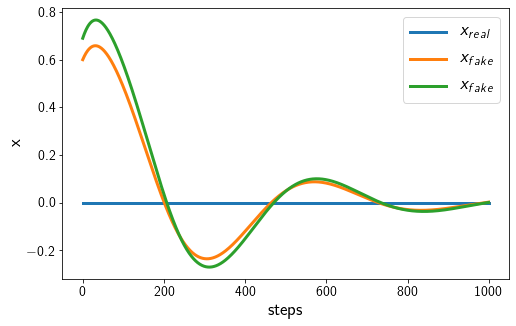

In [18]:
plt.figure(figsize=(8, 5))
K = 1000
plt.plot(tr_z_dirac_gp_1[:K, 0], linewidth=3, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac_gp_1[:K, 1], linewidth=3, c=palette[1], label='$x_{fake}$')
plt.plot(tr_z_dirac_gp_2[:K, 1], linewidth=3, c=palette[2], label='$x_{fake}$')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('x', fontsize=18)
plt.xlabel('steps', fontsize=18)
plt.legend(fontsize=18)
plt.show()

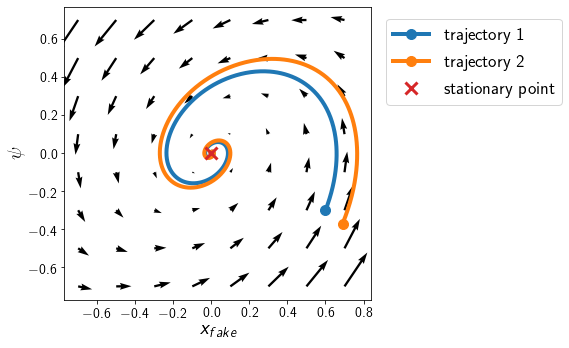

In [19]:
Z_gp, PSI_gp, Z_grad_gp, PSI_grad_gp = vector_field(
    z_grid=np.linspace(-0.7, 0.7, 8),
    psi_grid=np.linspace(-0.7, 0.7, 8),
    disc=DiscDirac(),
    disc_loss=lambda z_list, disc: disc_loss_dirac(z_list, disc) + l2_reg_loss(disc, d_gp_dirac_gp),
    gen_loss=gen_loss_dirac,
)

plt.figure(figsize=(5.5, 5.5))
plt.quiver(Z_gp, PSI_gp, Z_grad_gp * g_lr_dirac, PSI_grad_gp * d_lr_dirac)
plt.plot(tr_z_dirac_gp_1[:, 1], tr_psi_dirac_gp_1, linewidth=4, c=palette[0], label='trajectory 1',
         marker='o', markersize=10, markevery=(0, tr_z_dirac.shape[0]))
plt.plot(tr_z_dirac_gp_2[:, 1], tr_psi_dirac_gp_2, linewidth=4, c=palette[1], label='trajectory 2',
         marker='o', markersize=10, markevery=(0, tr_z_dirac.shape[0]))
plt.plot([0], [0], 'x', markersize=12, c=palette[3], markeredgewidth=3, label='stationary point')
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=20)
plt.ylabel('$\psi$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18, bbox_to_anchor=(1.02, 0.99), loc='upper left', ncol=1)
plt.show()

### Pairwise discriminator

In [20]:
z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.2], requires_grad=True)
]

D_dirac_pair = DiscPair()
D_dirac_pair.psi.data = torch.tensor([0.1])

g_lr_dirac_pair_conv = 0.003
d_lr_dirac_pair_conv = 0.003

tr_z_dirac_pair_1, tr_psi_dirac_pair_1 = run_gd(
    z_list, D_dirac_pair, gen_loss_pair, disc_loss_pair, 
    g_lr=g_lr_dirac_pair_conv, d_lr=d_lr_dirac_pair_conv, num_steps=1000, save_psi=True)

z_list = [
    torch.tensor([0.0], requires_grad=False),
    torch.tensor([0.24], requires_grad=True)
]

D_dirac_pair = DiscPair()
D_dirac_pair.psi.data = torch.tensor([0.13])

tr_z_dirac_pair_2, tr_psi_dirac_pair_2 = run_gd(
    z_list, D_dirac_pair, gen_loss_pair, disc_loss_pair, 
    g_lr=g_lr_dirac_pair_conv, d_lr=d_lr_dirac_pair_conv, num_steps=1000, save_psi=True)

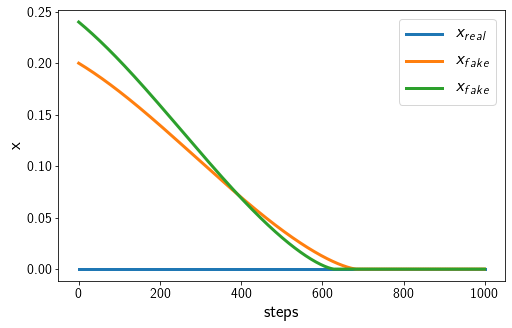

In [21]:
plt.figure(figsize=(8, 5))
K = 1000
plt.plot(tr_z_dirac_pair_1[:K, 0], linewidth=3, c=palette[0], label='$x_{real}$')
plt.plot(tr_z_dirac_pair_1[:K, 1], linewidth=3, c=palette[1], label='$x_{fake}$')
plt.plot(tr_z_dirac_pair_2[:K, 1], linewidth=3, c=palette[2], label='$x_{fake}$')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('x', fontsize=18)
plt.xlabel('steps', fontsize=18)
plt.legend(fontsize=18)
plt.show()

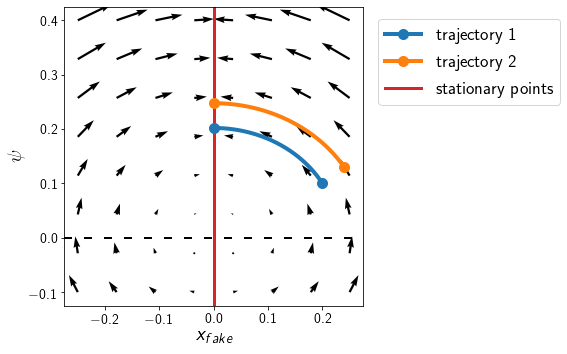

In [22]:
Z_pair_conv, PSI_pair_conv, Z_grad_pair_conv, PSI_grad_pair_conv = vector_field(
    z_grid=np.linspace(-0.25, 0.25, 8),
    psi_grid=np.linspace(-0.1, 0.4, 8),
    disc=DiscPair(),
    disc_loss=disc_loss_pair,
    gen_loss=gen_loss_pair,
)

plt.figure(figsize=(5.5, 5.5))
plt.axhline(0, linestyle='--', dashes=(4, 6), linewidth=2, c='k')
plt.quiver(Z_pair_conv, PSI_pair_conv, 
           Z_grad_pair_conv * g_lr_dirac_pair_conv, PSI_grad_pair_conv * d_lr_dirac_pair_conv)
plt.plot(tr_z_dirac_pair_1[:, 1], tr_psi_dirac_pair_1, linewidth=4, c=palette[0],
         marker='o', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=10, label='trajectory 1', zorder=3)
plt.plot(tr_z_dirac_pair_2[:, 1], tr_psi_dirac_pair_2, linewidth=4, c=palette[1],
         marker='o', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=10, label='trajectory 2', zorder=3)
plt.axvline(0, linestyle='-', linewidth=3, c=palette[3], label='stationary points', zorder=2)
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=20)
plt.ylabel('$\psi$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18, bbox_to_anchor=(1.02, 0.99), loc='upper left', ncol=1)
plt.show()

### Figure

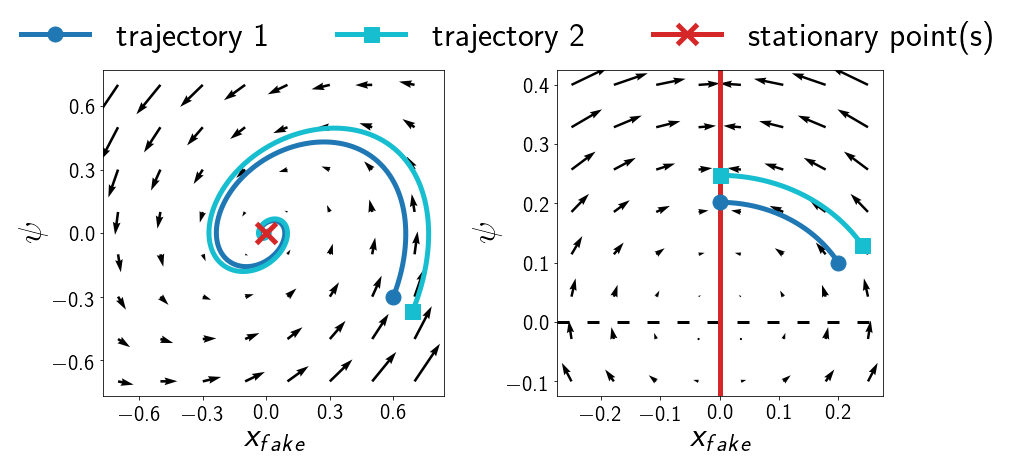

In [23]:
fig, axes = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)

plt.sca(axes[0])
plt.quiver(Z_gp, PSI_gp, Z_grad_gp * g_lr_dirac, PSI_grad_gp * d_lr_dirac)
plt.plot(tr_z_dirac_gp_1[:, 1], tr_psi_dirac_gp_1, linewidth=5, c=palette[0], label='trajectory 1',
         marker='o', markersize=15, markevery=(0, tr_z_dirac.shape[0]))
plt.plot(tr_z_dirac_gp_2[:, 1], tr_psi_dirac_gp_2, linewidth=5, c=palette[9], label='trajectory 2',
         marker='s', markersize=15, markevery=(0, tr_z_dirac.shape[0]))
plt.plot([0], [0], 'x', markersize=20, c=palette[3], markeredgewidth=5, label='stationary point')
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=34)
plt.ylabel('$\psi$', fontsize=34)
plt.xticks([-0.6, -0.3, 0.0, 0.3, 0.6], fontsize=22)
plt.yticks([-0.6, -0.3, 0.0, 0.3, 0.6], fontsize=22)

plt.sca(axes[1])
plt.axhline(0, linestyle='--', dashes=(4, 6), linewidth=3, c='k')
plt.quiver(Z_pair_conv, PSI_pair_conv,
           Z_grad_pair_conv * g_lr_dirac_pair_conv, PSI_grad_pair_conv * d_lr_dirac_pair_conv)
plt.plot(tr_z_dirac_pair_1[:, 1], tr_psi_dirac_pair_1, linewidth=5, c=palette[0],
         marker='o', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=15, label='trajectory 1', zorder=3)
plt.plot(tr_z_dirac_pair_2[:, 1], tr_psi_dirac_pair_2, linewidth=5, c=palette[9],
         marker='s', markevery=(0, tr_z_dirac_pair.shape[0] - 1), markersize=15, label='trajectory 2', zorder=3)
plt.axvline(0, ymin=-0.1, linestyle='-', linewidth=5, c=palette[3], label='stationary point(s)', zorder=2,
           marker='x', markersize=20, markeredgewidth=5, markevery=10000)
plt.gca().set_aspect('equal')
plt.xlabel('$x_{fake}$', fontsize=34)
plt.ylabel('$\psi$', fontsize=34)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=34, bbox_to_anchor=(-0.15, 1.1), loc='center', ncol=3, frameon=False)

plt.subplots_adjust(wspace=-0.2)
plt.savefig('./figures/fig_conv.pdf', format='pdf', bbox_inches='tight')
plt.show()